{'constants': {'c': 299792458.0}, 'cosmo_params': {'jla_norm': 25.0}, 'mcmc_params': {'n_walkers': 32}}
results/20220319_151100
MCMC
walkers:  32


 11%|█         | 106/1000 [00:02<00:21, 40.99it/s]

[9.55693618 9.93135019 9.1814984  9.99160747]


 20%|██        | 205/1000 [00:05<00:21, 36.17it/s]

[16.52863804 18.64074054 17.99303249 18.27371827]


 30%|███       | 305/1000 [00:07<00:18, 38.03it/s]

[18.71025977 25.53464337 24.98426558 24.17317163]


 41%|████      | 408/1000 [00:10<00:16, 36.13it/s]

[14.83698258 34.47594175 32.36213294 32.20942011]


 51%|█████     | 508/1000 [00:13<00:12, 40.07it/s]

[21.40336776 42.52780468 39.09783858 39.95255515]


 60%|██████    | 604/1000 [00:15<00:11, 35.61it/s]

[16.44509533 45.54392275 39.44193715 41.4954979 ]


 70%|███████   | 705/1000 [00:18<00:07, 37.46it/s]

[24.55653228 48.32626431 43.46286071 48.17112329]


 80%|████████  | 805/1000 [00:20<00:05, 34.35it/s]

[22.16095682 52.1794125  48.14746508 54.69247507]


 91%|█████████ | 907/1000 [00:23<00:02, 34.01it/s]

[23.78163914 56.7914988  50.05332671 58.75308997]


100%|██████████| 1000/1000 [00:25<00:00, 38.59it/s]


[32.29842951 59.02458379 54.24229783 59.76443847]
(32000, 4)


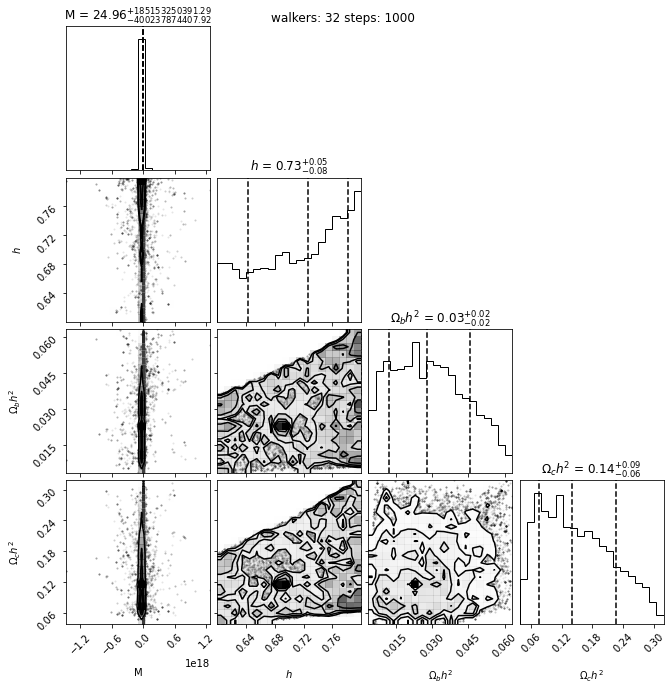

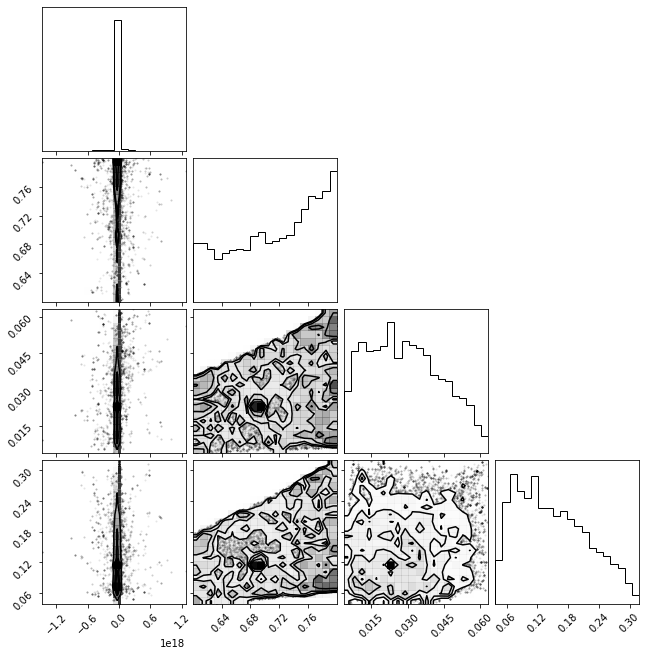

In [1]:
from datetime import datetime

import corner
import emcee
import matplotlib as plt
import numpy as np

import itm.likelihood
import itm.utils
from itm.likelihood_v2 import Prob
 
config_params = itm.utils.load_config("/Users/fabio/code/fchibana/tachyons/config.yaml")

print(config_params)

mcmc_params = config_params["mcmc_params"]


p0 = [24.96, 0.69, 0.022, 0.12]         # initial guess 
ndim = len(p0)  
nwalkers =  mcmc_params["n_walkers"] 

out_name = "results/" + datetime.now().strftime("%Y%m%d_%H%M%S")
print(out_name)

backend = emcee.backends.HDFBackend(out_name + ".h5")
backend.reset(nwalkers, ndim)


# # MCMC =============================================================================================

print("MCMC")
print("walkers: ", nwalkers)



# # initialize sampler
# sampler = emcee.EnsembleSampler(nwalkers, ndim, itm.likelihood.lnprob, backend=backend)

prob = Prob()
sampler = emcee.EnsembleSampler(nwalkers, ndim, prob.ln_probability, backend=backend)

# # condicoes iniciais dos walkers dentro da bola de centro p1_0
pos = [p0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

max_n = 1000

# # We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# # This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(pos, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    steps = sampler.iteration
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    print(tau)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau
    


# # Analysis ===========================================================================================

# tau = sampler.get_autocorr_time()
# burnin = int(2 * np.max(tau))
# thin = int(0.5 * np.min(tau))
# flat_samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)

flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)

fig = corner.corner(flat_samples,
                    labels=["M", "$h$",
                            "$\Omega_{b} h^2$", "$\Omega_{c} h^2$"],
                    quantiles=(0.16, 0.5, 0.84), show_titles=True,
                    title_kwargs={"fontsize": 12})
fig.suptitle('walkers: %s steps: %s' % (nwalkers, steps))
fig = corner.corner(flat_samples)
# fig.show()

fig.savefig(out_name + ".png")
